## Importing Required Libraries
The code begins by importing the necessary libraries for the task:

- `pandas` for data manipulation and analysis.
- `nltk` for natural language processing tasks.
- `string` for string operations.
- `re` for regular expressions.
- `matplotlib.pyplot` and `seaborn` for data visualization.
- `demoji` for handling emojis.
- `time` and `tqdm` for progress monitoring.
- `selenium` and related modules for web scraping.


In [4]:
import pandas as pd
import nltk

import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import demoji



from time import sleep
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as op
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from nltk import pos_tag
from selenium.common.exceptions import NoSuchElementException, WebDriverException

In [5]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

## Defining the `search` Function
The `search` function uses Selenium to search for a specific query on Google and retrieve a list of URLs for the top search results. It takes a `query` parameter as input and returns a list of URLs.


In [6]:

def search(query: str):
    options = op()
    options.add_argument("--headless") 
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36')
    driver = webdriver.Chrome(options=options)

    # Navigate to Google
    driver.get("https://www.google.com")

    # Wait for the search box to be visible
    wait = WebDriverWait(driver, 10)
    search_box = wait.until(EC.visibility_of_element_located((By.NAME, "q")))

    # Enter the query and submit
    search_box.send_keys(f"{query} review site: youtube.com")
    search_box.send_keys(Keys.RETURN)

    # Wait for the page to load
    driver.implicitly_wait(5)

    # Get the top 5 links
    links = driver.find_elements(By.XPATH, "//div[@class='ct3b9e']//a")
    urls = [link.get_attribute("href") for link in links[:15]]

    driver.quit()
    
    return urls


## Defining the `getComments` Function
The `getComments` function uses Selenium to scrape comments from a given URL. It takes a `url` parameter as input and returns a list of comments found on the page.

### Setting Up Chrome Driver and Scraping Comments
The code then sets up the Chrome driver options and initializes it with an implicit wait of 10 seconds. It also defines a constant for the scroll pause time.





In [7]:
def getComments(url):
    
    # Set up Chrome driver options
    chrome_options =op()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    # Initialize ChromeDriver with an implicit wait of 10 seconds
    driver = webdriver.Chrome(options=chrome_options)
    driver.implicitly_wait(20)

    # Open the video page
    driver.get(url)
    sleep(15)

    # Wait for the comment section to load
    wait = WebDriverWait(driver, 20)
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="continuations"]')))

    SCROLL_PAUSE_TIME = 14
    last_height = driver.execute_script("return document.documentElement.scrollHeight")
    scrolls = 0
    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        scrolls += 1
        if scrolls >= 15:
            break


    # Find the comment div element and extract the comments
    comment_list = []
    try:
        comment_div = driver.find_element(By.XPATH, '//*[@id="contents"]')
        comments = comment_div.find_elements(By.XPATH, '//*[@id="content-text"]')
        for comment in comments:
            comment_list.append(comment.text.strip())
    except NoSuchElementException:
        print("Could not find comment section.")
    finally:
        driver.quit()
        return comment_list


In [8]:
query = "pixel fold"
urls = search(query)

In [9]:
urls

['https://www.youtube.com/watch?v=9wobcM-WPQk',
 'https://www.youtube.com/watch?v=qtdb2y1DQn8',
 'https://www.youtube.com/watch?v=zxDTitg2MeE',
 'https://www.youtube.com/watch?v=3yS2zQ7VNoo',
 'https://www.youtube.com/watch?v=B2Tifdbh3w0',
 'https://www.youtube.com/watch?v=g_DHKoj7n8U',
 'https://www.youtube.com/watch?v=oqyPr-bLQKE',
 'https://www.youtube.com/watch?v=WjifphwIbI8',
 'https://www.youtube.com/watch?v=Qi5BNlojsyw',
 'https://www.youtube.com/watch?v=9-yoIW_EM9A']

The `getComments` function is called for each URL obtained from the search results. The comments are collected and stored in a list.

In [7]:
comments = []
for url in tqdm(urls):
    sleep(10)
    com = getComments(url)
    comments.extend(com)
    
    

In [8]:
df = pd.DataFrame({'comments':comments})

In [13]:
df

,comments
0,I learned a few more bits and pieces about the...
1,Really excited about this one - but I think it...
2,Respect to Google for letting the folding tech...
3,Went from fold 3 to fold 4. Had my eyes on the...
4,"Using the terms ""Dorsal and Ventral, Port and ..."
...,...
1813,Google fell off when they stopped using Snapdr...
1814,Chineas foldables beat that
1815,Too expensive with less feature and slower pro...
1816,The cameras aren't $500 better than the Find N...


In [14]:
# df.to_csv(f'{query}_comments.csv', index = False)

In [15]:
# df = pd.read_csv(f'{query}_comments.csv')

## Sentiment Analysis
The code defines the `analyze_sentiments` function for sentiment analysis. It cleans the comments using the `clean_text` function, applies sentiment analysis using the `SentimentIntensityAnalyzer` from NLTK, extracts the compound score from the sentiment scores, and categorizes the comments as positive, negative, or neutral based on the compound score.


## Loading and Cleaning the Data
The code loads the collected comments into a pandas DataFrame and converts the data to string type. It defines a function `clean_text` for cleaning the text by converting it to lowercase, removing device names, terms related to the device, punctuation marks, numbers, special characters, URLs, mentions, and emojis. It also tokenizes the text, removes stop words and non-noun words, and applies stemming.


In [28]:

def clean_text(text, device_name=query):
    # Convert text to lowercase
    text = text.lower()

    # Remove device name
    device_name = device_name.lower()
    device_name_terms = [term.strip() for term in device_name.split()]
    device_name_regex = '|'.join(device_name_terms)
    text = re.sub(device_name_regex, '', text)

    # Remove terms related to device
    remove_terms = ['phone', 'review', 'use', 'upgrade', 'year', 'video', 'watch', 'note', 'life', 'google', 'galaxy', 'abl', 'will'] + device_name_terms
    remove_terms_regex = '|'.join(remove_terms)
    text = re.sub(remove_terms_regex, '', text)

    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers and special characters
    text = re.sub('[^a-zA-Z ]', '', text)

    # Remove URLs and mentions
    text = re.sub(r'http\S+', '', text)
    text = re.sub('@[^\s]+', '', text)

    # Remove emojis
    text = remove_emojis(text)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stop words and non-noun words
    stop_words = set(stopwords.words('english'))
    pos_words = []
    for word, pos in pos_tag(words):
        if len(word) > 2:
            pos_words.append(word)

    # Stem the words
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in pos_words]

    # Join the words back into a string
    text = ' '.join(words)

    return text

def remove_emojis(text):
    return demoji.replace(text, '')


In [29]:
def analyze_sentiments(df):
    # Clean the comments
    df['cleaned_comments'] = df.comments.apply(clean_text)
    df['cleaned_comments'] = df.cleaned_comments.apply(remove_emojis)

    # Create an instance of the sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Apply the sentiment analyzer to each comment
    df['sentiment_scores'] = df['cleaned_comments'].apply(lambda x: sid.polarity_scores(x))

    # Extract the compound score from the sentiment scores
    df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])

    # Categorize the comments as positive, negative, or neutral based on the compound score
    df['sentiment_category'] = pd.cut(df['compound_score'], bins=3, labels=['negative', 'neutral', 'positive'])
    
    return df

In [30]:
df = analyze_sentiments(df)

In [31]:
df

,comments,cleaned_comments,sentiment_scores,compound_score,sentiment_category
0,I learned a few more bits and pieces about the...,learn few more bit and piec about the while ro...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,Really excited about this one - but I think it...,realli excit about this one but think need gen...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.6124,positive
2,Respect to Google for letting the folding tech...,respect for let the ing tech connoisseur take ...,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...",0.4767,positive
3,Went from fold 3 to fold 4. Had my eyes on the...,went from had eye the but glad threw their hat...,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...",0.6124,positive
4,"Using the terms ""Dorsal and Ventral, Port and ...",use the term dorsal and ventral port and starb...,"{'neg': 0.074, 'neu': 0.818, 'pos': 0.108, 'co...",0.3182,neutral
...,...,...,...,...,...
1813,Google fell off when they stopped using Snapdr...,fell off when they stop use snapdragonif not s...,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou...",-0.5583,negative
1814,Chineas foldables beat that,chinea beat that,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1815,Too expensive with less feature and slower pro...,too expens with less featur and slower processor,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1816,The cameras aren't $500 better than the Find N...,the camera arent better than the find this thi...,"{'neg': 0.177, 'neu': 0.823, 'pos': 0.0, 'comp...",-0.5432,negative


## Generating Word Cloud
The code defines the `generate_wordcloud` function for generating a word cloud based on the cleaned comments. It joins the words in the comments to a single string, creates a word cloud object, and plots the word cloud using `matplotlib.pyplot`.


In [32]:

def generate_wordcloud(df):
    # Join the words in the cleaned comments to a single string
    text = ' '.join(df['cleaned_comments'])

    # Create a word cloud object and generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


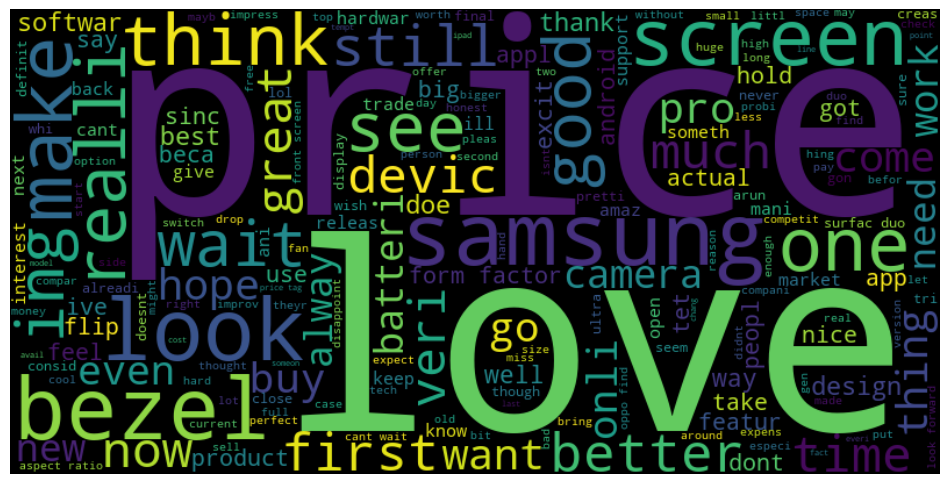

In [33]:
generate_wordcloud(df)

## Plotting Sentiment Counts
The code defines the `plot_sentiment_counts` function for plotting the count of comments in each sentiment category. It uses `seaborn` to set the style and color palette, retrieves the count of comments in each category, and plots a bar chart to visualize the results.


In [34]:

def plot_sentiment_counts(df):
    # Set the style and color palette
    sns.set_style('darkgrid')
    sns.set_palette('husl')

    # Get the count of comments in each sentiment category
    sentiment_counts = df['sentiment_category'].value_counts().sort_index()

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax)
    ax.set_xlabel('Sentiment Category')
    ax.set_ylabel('Number of Comments')
    ax.set_title('Sentiment Analysis Results')

    # Add labels to the bars
    for i, v in enumerate(sentiment_counts.values):
        ax.text(i, v+10, str(v), ha='center', fontweight='bold', fontsize=12)

    # Label the bars
    for i, label in enumerate(ax.get_xticklabels()):
        sentiment = label.get_text()
        if sentiment == 'positive':
            label.set_text(f'{sentiment.capitalize()} comments')
            label.set_color('green')
        elif sentiment == 'neutral':
            label.set_text(f'{sentiment.capitalize()} comments')
            label.set_color('gray')
        else:
            label.set_text(f'{sentiment.capitalize()} comments')
            label.set_color('red')
            # Update the label for negative sentiment category
            label.set_text(f'{sentiment.capitalize()} comments ({sentiment_counts[sentiment]})')
        label.set_fontweight('bold')
        label.set_fontsize(12)

    plt.show()


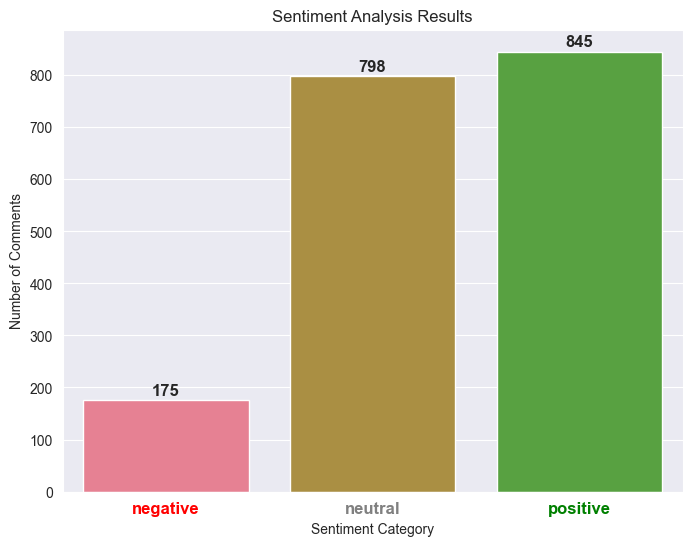

In [35]:

plot_sentiment_counts(df)


## Plotting Word Frequencies
The code defines the `plot_word_frequencies` function for plotting the most frequent words in each sentiment category. It tokenizes the comments, removes stop words, counts the frequency of each word, and plots the top 20 most frequent words in each category using subplots.

### Tokenizing Comments
The code defines the `tokenize_comments` function for tokenizing comments. It combines all comments into a single string, tokenizes the string into words, and removes stop words.


In [36]:

def plot_word_frequencies(df):
    # Define the stop words
    stop_words = set(stopwords.words('english'))

    # Define the minimum word frequency threshold
    min_freq = 10

    # Create separate dataframes for each sentiment category
    positive_df = df[df['sentiment_category'] == 'positive']
    neutral_df = df[df['sentiment_category'] == 'neutral']
    negative_df = df[df['sentiment_category'] == 'negative']

    # Tokenize the comments and remove stop words for each dataframe
    positive_words = tokenize_comments(positive_df['cleaned_comments'])
    neutral_words = tokenize_comments(neutral_df['cleaned_comments'])
    negative_words = tokenize_comments(negative_df['cleaned_comments'])

    # Count the frequency of each word in each dataframe
    positive_freq = nltk.FreqDist(positive_words)
    neutral_freq = nltk.FreqDist(neutral_words)
    negative_freq = nltk.FreqDist(negative_words)

    # Remove words that appear less frequently than the minimum frequency threshold
    positive_freq = {k: v for k, v in positive_freq.items() if v >= min_freq}
    neutral_freq = {k: v for k, v in neutral_freq.items() if v >= min_freq}
    negative_freq = {k: v for k, v in negative_freq.items() if v >= min_freq}

    # Sort the dictionaries by word frequency in descending order
    positive_freq = dict(sorted(positive_freq.items(), key=lambda item: item[1], reverse=True))
    neutral_freq = dict(sorted(neutral_freq.items(), key=lambda item: item[1], reverse=True))
    negative_freq = dict(sorted(negative_freq.items(), key=lambda item: item[1], reverse=True))

    # Plot the top 20 most frequent words in each sentiment category
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.bar(list(positive_freq.keys())[:20], list(positive_freq.values())[:20])
    plt.title('Most Frequent Words in Positive Comments')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.subplot(3, 1, 2)
    plt.bar(list(neutral_freq.keys())[:20], list(neutral_freq.values())[:20])
    plt.title('Most Frequent Words in Neutral Comments')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.subplot(3, 1, 3)
    plt.bar(list(negative_freq.keys())[:20], list(negative_freq.values())[:20])
    plt.title('Most Frequent Words in Negative Comments')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def tokenize_comments(comment_series):
    # Combine the comments into a single string
    all_comments = ' '.join(comment_series.tolist())

    # Tokenize the string into words
    words = word_tokenize(all_comments)

    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]

    return filtered_words


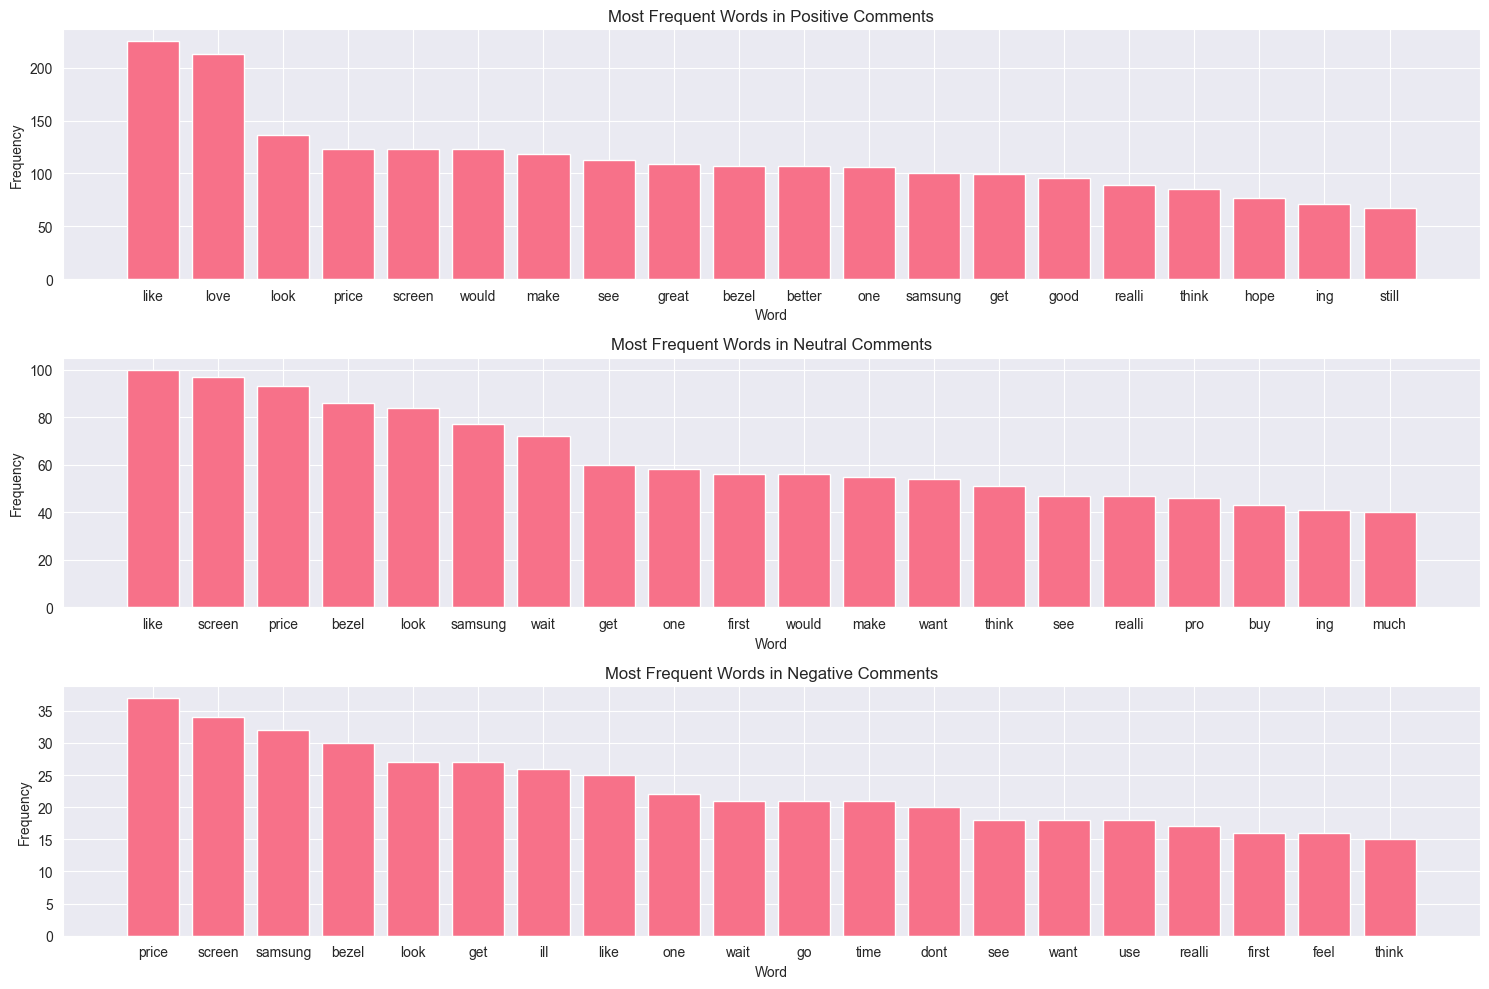

In [37]:
plot_word_frequencies(df)

# Analysis Conclusion

## Overview
This sentiment analysis focused on examining the public reactions regarding the latest Pixel Fold smartphone, which marks Google's entry into the folding phone market. The aim was to gain insights into the sentiments surrounding this innovative device.

## Findings
The findings indicate that the Pixel Fold smartphone was generally well-received by people, which is a positive outcome for Google. However, there were notable factors related to price and design that require further attention and consideration.

### Sentiment Analysis
The sentiment analysis revealed an overall positive sentiment surrounding the Pixel Fold device, with a significant number of neutral comments also present.

### Word Cloud
The word cloud generated from the comments suggests that key factors to be examined further include the bezel of the device, the price, and the screen.

### Sentiment Counts
The sentiment counts clearly indicate that positive comments had the highest count at 845, which suggests a positive reception of the device within the YouTube comment sections of tech videos.

### Word Frequencies
The word frequencies in the positive comments highlighted the prominence of terms like "like" and "love," further affirming the positive response towards the device.

## Insights and Implications
Based on this analysis, it can be inferred that Google is on the right track with the Pixel Fold smartphone. However, improvements are needed, particularly in the design and battery aspects.

## Limitations
It's important to acknowledge the limitations of this analysis. The categorization of comments by the model encountered challenges, and the tokenization method used may need refinement for more accurate results.

## Future Work
Future work could involve building a frontend for the project using Flask or Django, where users can input a device name, and the sentiment analysis will be provided in a well-formatted link on GitHub for collaboration.

## References
- YouTube Videos:
    - [Video 1](https://www.youtube.com/watch?v=9wobcM-WPQk)
    - [Video 2](https://www.youtube.com/watch?v=qtdb2y1DQn8)
    - [Video 3](https://www.youtube.com/watch?v=zxDTitg2MeE)
    - [Video 4](https://www.youtube.com/watch?v=3yS2zQ7VNoo)
    - [Video 5](https://www.youtube.com/watch?v=B2Tifdbh3w0)
    - [Video 6](https://www.youtube.com/watch?v=g_DHKoj7n8U)
    - [Video 7](https://www.youtube.com/watch?v=oqyPr-bLQKE)
    - [Video 8](https://www.youtube.com/watch?v=WjifphwIbI8)
    - [Video 9](https://www.youtube.com/watch?v=Qi5BNlojsyw)
    - [Video 10](https://www.youtube.com/watch?v=9-yoIW_EM9A)
